**For tqdm progress bar to work correctly, before launching this notebook run:**
```bash
$ jupyter nbextension enable --py --sys-prefix widgetsnbextension
```

**Or simply run from project root:**
```bash
$ make jupyter
```
### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import (accuracy_score,
                             confusion_matrix)

import env
from bm.rbm import BernoulliRBM
from bm.utils import (Stopwatch, RNG, 
                       im_plot, plot_confusion_matrix)
from bm.utils.dataset import load_mnist

%matplotlib inline
%load_ext autoreload
%autoreload 2

## load trained RBM model

In [2]:
rbm = BernoulliRBM.load_model('../models/rbm_mnist/')

# visualize learned filters

In [3]:
weights = rbm.get_tf_params(scope='weights')
W = weights['W']
hb = weights['hb']

INFO:tensorflow:Restoring parameters from ../models/rbm_mnist/model


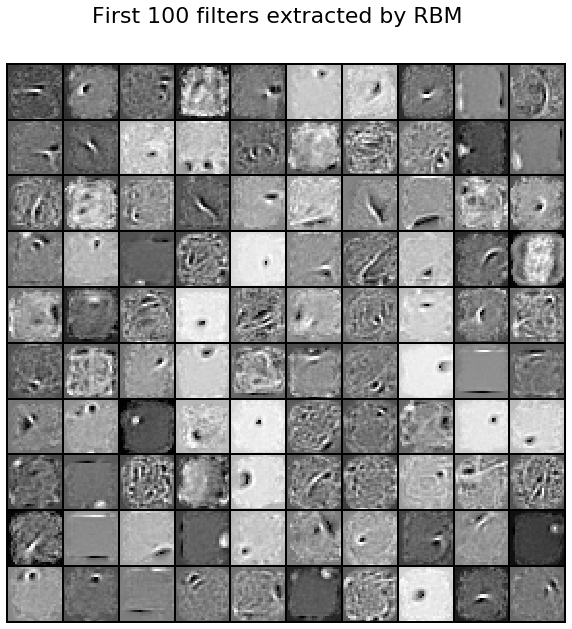

In [4]:
fig = plt.figure(figsize=(10, 10))
im_plot(W.T, shape=(28, 28), title='First 100 filters extracted by RBM',
        imshow_params={'cmap': plt.cm.gray});
plt.savefig('rbm_mnist.png', dpi=196);

## load data

In [5]:
X, y = load_mnist(mode='train', path='../data/')
X /= 255.
X_test, y_test = load_mnist(mode='test', path='../data/')
X_test /= 255.
print X.shape, y.shape, X_test.shape, y_test.shape

(60000, 784) (60000,) (10000, 784) (10000,)


# 1) train classifiers on extracted features
## extract features $\mathbf{q}_i=p(\mathbf{h}\;|\;\mathbf{v}=\mathbf{x}_i)$

In [6]:
Q = rbm.transform(X)
Q_test = rbm.transform(X_test)
print Q.shape, Q_test.shape

INFO:tensorflow:Restoring parameters from ../models/rbm_mnist/model


A Jupyter Widget

INFO:tensorflow:Restoring parameters from ../models/rbm_mnist/model


A Jupyter Widget

(60000, 1024) (10000, 1024)


## fit Logistic Regression

In [7]:
logreg = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=800,
                            verbose=10, n_jobs=2, random_state=1337)
logreg.fit(Q, y)
print accuracy_score(y_test, logreg.predict(Q_test))

max_iter reached after 2320 seconds
0.9821


/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed: 38.7min
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed: 38.7min finished


## fit k-NN

In [8]:
knn = KNN(n_neighbors=3, p=2., weights='distance', 
          n_jobs=2)

with Stopwatch(verbose=True) as s:
    knn.fit(Q, y)
    print accuracy_score(y_test, knn.predict(Q_test))

0.9696
Elapsed time: 464.985 sec


# 2) discriminative finetuning: initialize 2-layer MLP with learned parameters $\boldsymbol{\psi}$ and train using backprop
## load predictions, targets, and fine-tuned weights

In [9]:
y_pred = np.load('../data/rbm_y_pred.npy')
y_test = np.load('../data/rbm_y_test.npy')
W_finetuned = np.load('../data/rbm_W_finetuned.npy')
print accuracy_score(y_test, y_pred)

0.9867


## plot confusion matrix

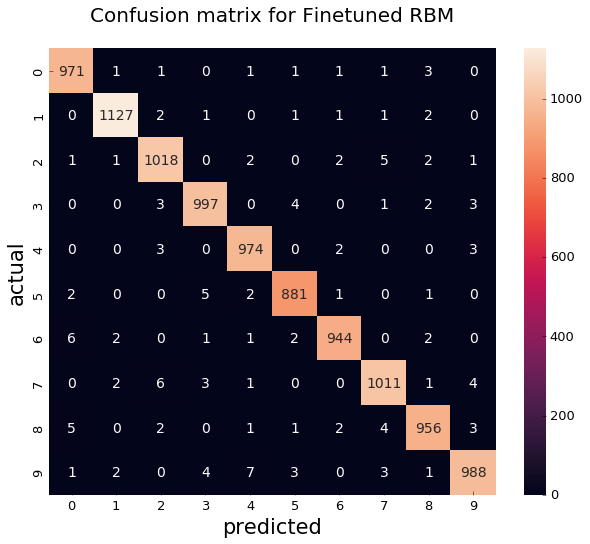

In [10]:
C = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(10, 8))
ax = plot_confusion_matrix(C, fmt='d')
plt.title('Confusion matrix for Finetuned RBM\n', fontsize=20)
plt.savefig('rbm_mnist_confusion_matrix.png', dpi=144)

## visualize filters after fine-tuning

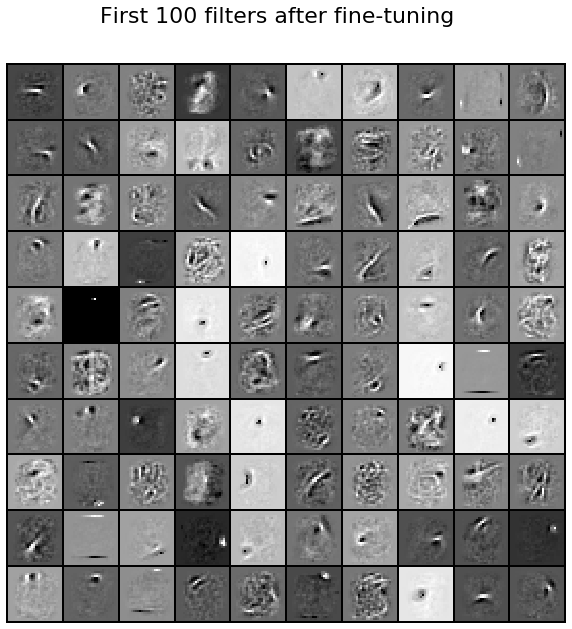

In [11]:
fig = plt.figure(figsize=(10, 10))
im_plot(W_finetuned.T, shape=(28, 28), title='First 100 filters after fine-tuning',
        imshow_params={'cmap': plt.cm.gray});
plt.savefig('rbm_mnist_finetuned.png', dpi=196);

# 3) classification RBMs
A third way to use RBMs for supervised problems is to jointly model distribution of the data along with the labels $\mathbb{P}(\mathbf{x},\;\mathbf{y})$. Such models are called **classification RBMs** (cRBMs). Currently, these are beyond of the scope of this repository.